# Satellite Image Segmentation of Nepal
**Prepared By:** Ajeeb Rimal | M. Tech. AI | Kathmandu University

## Notebook setup and imports

In [23]:

%reload_ext autoreload
%autoreload 2

import os
import random
import matplotlib.pyplot as plt
import rasterio
from torchvision.transforms import transforms

from sources.helpers.generator import NepalDataset, NepalDataGenerator
from sources.helpers.pan import PAN
from sources.helpers.train import train_model
from sources.helpers.utils import create_patches, visualize,rasterize_masks,setup_logger

#### Logger Setup

## Directory definitions
We have defined the directory paths for the dataset, image, and mask files. We have also defined and created the output directory where the patches will be saved.Additionally we have defined the patch size, stride, and boundary for the patches. The boundary is defined as a list of four values: [min_x, min_y, max_x, max_y] which represent the minimum and maximum x and y coordinates of the area of interest, respectively. We have used the `os` library to create the output directory if it does not exist.

In [26]:
mission_list = ['Mission 1', 'Mission 2', 'Mission 3', 'Mission 4', 'Mission 5']
dataset_dir = os.path.join('/', 'Users', 'ajeebrimal', 'Documents', 'Masters Thesis', 'Datasets', 'Rupandehi Data')
annotations_dir = os.path.join(dataset_dir, 'Annotations')
image_dir = os.path.join(dataset_dir, 'TIF Files') 
mask_dirs = [os.path.join(annotations_dir, mask_dir) for mask_dir in mission_list]
mask_paths = [os.path.join(mask_dir, f'{mission}.shp') for mask_dir, mission in zip(mask_dirs, mission_list)]
image_paths = [os.path.join(image_dir, f'{mission}.tif') for mission in mission_list]

In [28]:
output_dir = os.path.join('..', 'output')
os.makedirs(output_dir, exist_ok=True)

rasterized_dir = os.path.join(output_dir, 'rasterized_outputs')
os.makedirs(rasterized_dir, exist_ok=True)

mask_paths_rasterized = [os.path.join(rasterized_dir, f'{mission}_rasterized.tif') for mission in mission_list]

In [29]:
patch_size = 512
stride = 256
boundary = [3053710.461731, 751158.377075, 3055429.699707, 753175.112122]

patch_output_dir = os.path.join(output_dir, f"{patch_size}x{patch_size}")
os.makedirs(patch_output_dir, exist_ok=True)

labels_output_dir = os.path.join(patch_output_dir, 'labels')
os.makedirs(labels_output_dir, exist_ok=True)

In [30]:
# Ensure the log directory exists
log_dir = os.path.join('..', 'logs')
os.makedirs(log_dir, exist_ok=True)

logger = setup_logger(log_dir)
logger.info("Logger setup complete.")

2025-01-22 22:15:24,114 - ./logs - INFO - Logger setup complete. [in /var/folders/wd/hjtm8j014ssf90kvk6rjl1pw0000gn/T/ipykernel_77558/83787627.py:6]


## Dataset preparation

### Rasterize the mask
Rasterize the mask to the same projection and pixel resolution as the reference image. We have used the `gdal` library to rasterize the mask. The `gdal` library is a translator library for raster and vector geospatial data formats. It also includes a variety of useful command-line utilities for data translation and processing.

In [ ]:
import os
import concurrent.futures

# Use ThreadPoolExecutor to run rasterization in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(rasterize_masks, image_file_path, mask_shape_file_path,rasterized_dir,logger) for image_file_path, mask_shape_file_path in zip(image_paths, mask_paths)]
    concurrent.futures.wait(futures)

### Visualize the image and its rasterized mask
We can visualize the image and the rasterized mask using the `matplotlib` library. The `matplotlib` library is a plotting library for the Python programming language and its numerical mathematics extension, NumPy. We can use the `imshow()` function from the `matplotlib.pyplot` module to display the image and the mask.

In [ ]:
# # Open the rasters
# with rasterio.open(image_paths[0]) as raster1:
#     temp_img = raster1.read()  # Read raster1 into numpy array
# 
# with rasterio.open(mask_paths_rasterized[0]) as raster2:
#     temp_mask = raster2.read(1)  # Read raster2 into numpy array
# 
# labels, count = np.unique(temp_mask, return_counts=True)  #Check for each channel. All channels are identical
# print('Unique values in mask: ', labels)
# print('Counts of unique values: ', count)

In [ ]:
# # The image data read by Rasterio is in (bands, rows, cols) order
# # Convert the image data to (rows, cols, bands) order for visualization
# transposed_image = temp_img.transpose((1, 2, 0)).astype('float64')
# 
# # Scale the image data to be between 0 and 1 for better visualization
# transposed_image -= transposed_image.min()
# transposed_image /= transposed_image.max()
# 
# plt.figure(figsize=(12, 8))
# # Plot raster1
# plt.imshow(temp_img, interpolation='nearest')
# # Overlay raster2, make sure to use the same extent 
# plt.imshow(temp_mask, interpolation='nearest', cmap='tab10', alpha=0.4)
# plt.show()
# 
# print('Image shape: ', temp_img.shape)
# print('Mask shape: ', temp_mask.shape)

### Create image and mask patches

To prepare the satellite images and masks for segmentation, we first need to convert them into smaller patches. Here's how we can do it:

1. Use the `create_patches()` function from the `utils` module.
2. Pass the following parameters to the function:
    - The file path of the satellite image in `.tif` format.
    - The file path of the mask in `.shp` format.
    - The output directory where the created patches will be saved.
    - The patch size (we use the same value for height and width).
    - The stride.
    - A boundary that defines the area of interest.
3. The function will iterate over the satellite image in patches of the specified size and stride.
4. For each patch, the function will check if it intersects with any mask geometries (which are shapes such as polygons, lines, points, etc. that represent the features belonging to certain classes).
5. If the patch intersects with any mask geometries, the function will create a patch mask by rasterizing the intersecting mask geometries. Otherwise, it will discard the patch.
6. The function will save the patch and its corresponding patch mask to the output directory.

In [6]:
from sources.helpers.utils import create_patches_one_hot, create_patches_categorical

min_mask_coverage=0.1 # Percentage of minimum mask coverage in the patch

# Iterate over image and mask paths
for image_path, mask_path in zip(image_paths, mask_paths_rasterized):
    # Pass `outer_pbar` to the inner function
    create_patches_categorical(
        image_path=image_path,
        mask_path=mask_path,
        output_dir=patch_output_dir,
        patch_size=patch_size,
        stride=stride,
        logger=logger,
        min_mask_coverage=min_mask_coverage
    )

Patches for Mission 1:   0%|          | 0/18875 [00:00<?, ?patch/s]

2025-01-13 00:20:10,558 - ./logs - INFO - Completed: 'Mission 1' with 18875 patches processed, 2903 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 2:   0%|          | 0/14940 [00:00<?, ?patch/s]

2025-01-13 00:20:28,778 - ./logs - INFO - Completed: 'Mission 2' with 14940 patches processed, 2465 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 3:   0%|          | 0/14762 [00:00<?, ?patch/s]

2025-01-13 00:20:55,760 - ./logs - INFO - Completed: 'Mission 3' with 14762 patches processed, 4962 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 4:   0%|          | 0/9694 [00:00<?, ?patch/s]

2025-01-13 00:21:07,531 - ./logs - INFO - Completed: 'Mission 4' with 9694 patches processed, 1547 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


Patches for Mission 5:   0%|          | 0/10088 [00:00<?, ?patch/s]

2025-01-13 00:21:21,964 - ./logs - INFO - Completed: 'Mission 5' with 10088 patches processed, 1807 patches saved [in /Users/ajeebrimal/Documents/Masters Thesis/Projects/aerial-satellite-imagery-segmentation-nepal/utils.py:423]


### Visualize a random image patch and its mask
We can visualize a random patch and its mask using the `rasterio` and `matplotlib` libraries. The `rasterio` library is a Python package that provides a fast and direct way to work with raster data. We can use the `rasterio.open()` function to open the image and mask files. We can then use the `read()` function to read the image and mask data. We can then use the `imshow()` function from the `matplotlib.pyplot` module to display the image and the mask.

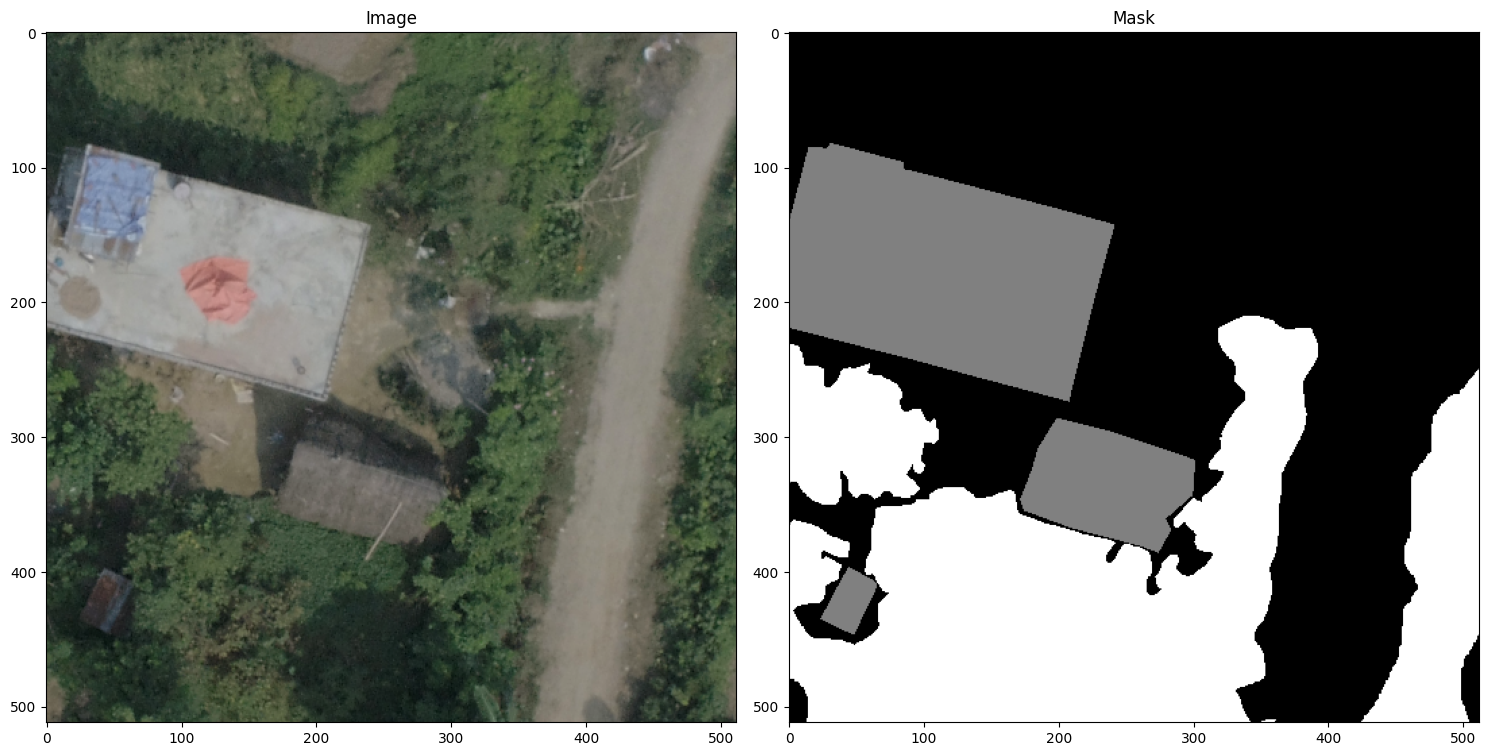

Image shape:  (4, 512, 512)
Mask shape:  (1, 512, 512)


In [33]:
# Get list of all image files in the directory
image_files = [f for f in os.listdir(patch_output_dir + "/images") if f.endswith('.jpg')]

# Select a random image file
random_image_file = random.choice(image_files)

# Construct the full paths to the image and mask files
temp_image_path = os.path.join(patch_output_dir, "images", random_image_file)
basename, ext = os.path.splitext(random_image_file)
mission_part, patch_part = basename.split("_patch_", 1)
temp_mask_path = os.path.join(patch_output_dir, "masks", f"{mission_part}_rasterized_patch_{patch_part}_mask{ext}")

# Open the image and mask files using Rasterio
with rasterio.open(temp_image_path) as src:
    image = src.read().astype(float)
    image_transform = src.transform

with rasterio.open(temp_mask_path) as src:
    mask = src.read()
    mask_transform = src.transform

# The image data read by Rasterio is in (bands, rows, cols) order
# Convert the image data to (rows, cols, bands) order for visualization
transposed_image = image.transpose((1, 2, 0))

# Scale the image data to be between 0 and 1 for better visualization
transposed_image -= transposed_image.min()
transposed_image /= transposed_image.max()

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Display the image
ax[0].imshow(transposed_image)
ax[0].set_title("Image")

# Display the mask
ax[1].imshow(mask[0], cmap='gray')
ax[1].set_title("Mask")

plt.tight_layout()
plt.show()

print('Image shape: ', image.shape)
print('Mask shape: ', mask.shape)

### Dataset and data generator

We define the dataset and data generator that will be used for training the model. To define the dataset and data generator, we can use the `NepalDataset` and `NepalDataGenerator` classes from the `dataset` module. This code takes a dataset and generates batches of data for training a deep learning model.

In [37]:
data_path = patch_output_dir
in_channels = 4
num_classes = 3
batch_size = 4
shuffle = True

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = NepalDataset(data_path, transform=transform)
print(f"Dataset size: {format(len(dataset))}")
data_generator = NepalDataGenerator(dataset, batch_size=batch_size, shuffle=shuffle)
print(f"Data generator size: {format(len(data_generator))}")

Dataset size: 13684
Data generator size: 3421


### Visualize data generator output image and mask patches

This code visualizes the patches and patch masks that were created using the data generator. To visualize the patches and patch masks, we can use the `visualize()` function from `utils` module.

Image shape: (512, 512, 4)
Mask shape: (512, 512)


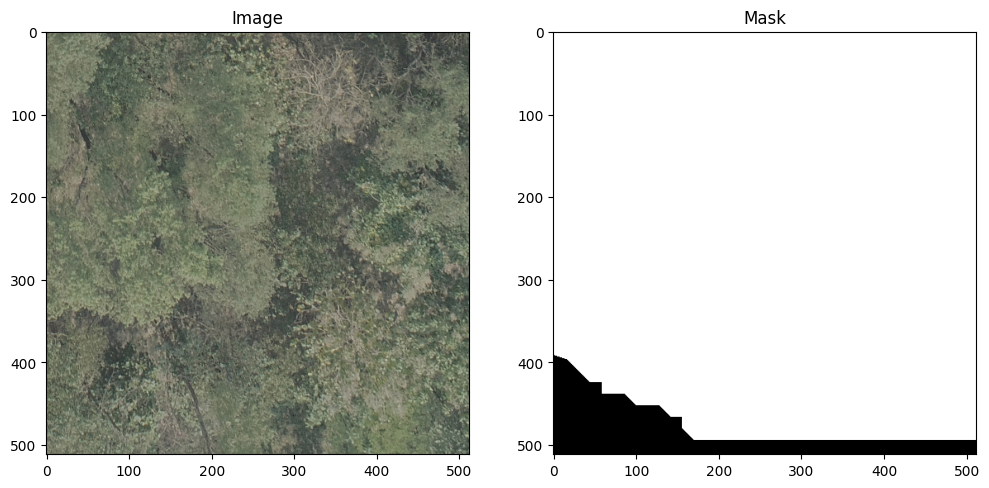

Image shape: (512, 512, 4)
Mask shape: (512, 512)


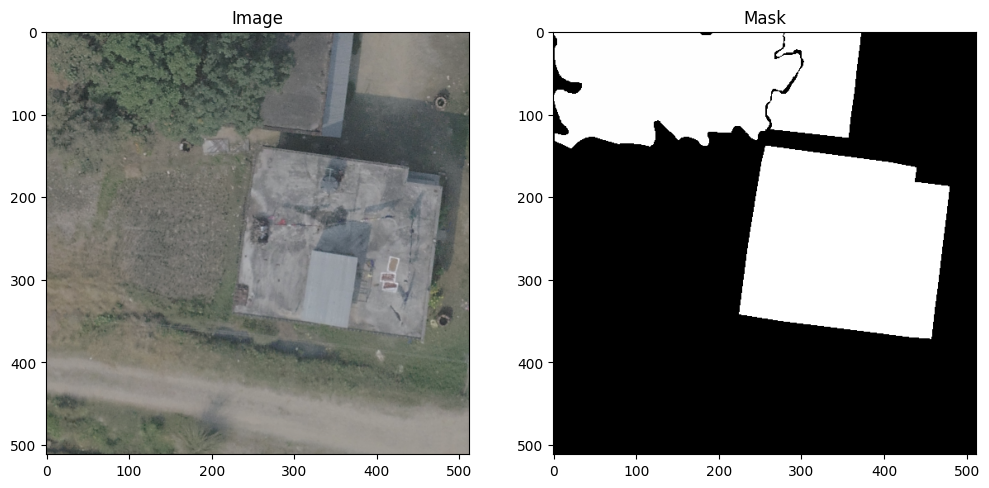

Image shape: (512, 512, 4)
Mask shape: (512, 512)


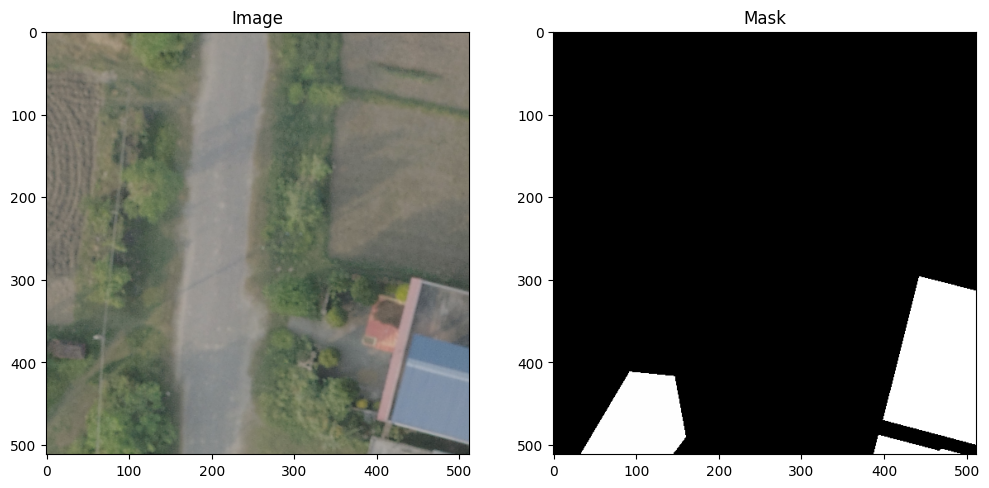

In [39]:
no_of_images_to_show = 3  # Number of images to show from the batch

images, masks = data_generator.__next__()  # Get the batch of images and masks

if no_of_images_to_show > batch_size:
    no_of_images_to_show = batch_size

for i in range(0, no_of_images_to_show):
    image = images[i].permute(1, 2, 0).numpy()  # Access individual image and convert to numpy array
    mask = masks[i].squeeze().numpy()  # Access individual mask and convert to numpy array
    visualize(image, mask)

## Model training

In [ ]:
pan_model = PAN(in_channels)
train_model(pan_model, data_generator)

### Yolo V8 Data Preparation

In [ ]:

from shapely.geometry import Polygon
import tifffile


def mask_to_polygons(img_path, mask_path):
    '''
    Convierte una máscara de imagen en polígonos. Devuelve dos listas:
    - Lista de polígonos de shapely sin normalizar
    - Lista de polígonos de shapely normalizados (coordenadas entre 0 y 1)

    Args:
        img_path (str): Ruta al archivo de imagen original.
        mask_path (str): Ruta al archivo de la máscara en escala de grises.
    '''

    mask = tifffile.imread(mask_path)

    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Calcula los contornos 
    mask = mask.astype(bool)
    #contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convertimos los contornos a polígonos de Label Studio
    polygons = []
    normalized_polygons = []
    for contour in contours:

        # Lo meto en un try porque la extraccion de polígonos que hace el opencv a partir de la máscara
        # a veces genera polígonos de menos de 4 vértices, que no tiene sentido por no ser cerrados, 
        # provocando que falle al convertir a polígno de shapely

        try:
            polygon = contour.reshape(-1, 2).tolist()

            # normalizamos las coordenadas entre 0 y 1 porque así lo requiere YOLOv8
            normalized_polygon = [[round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)] for coord in
                                  polygon]

            # Convertimos a objeto poligono de shapely (sin normalizar)
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            # normalizdos
            normalized_polygons.append(Polygon(normalized_polygon))


        except Exception as e:
            pass

    return polygons, normalized_polygons

In [ ]:
def mask_to_polygons_per_class(img_path, mask_path):
    # Map grayscale mask values to your class indices
    class_mapping = {0: 0, 1: 1, 2: 2}

    mask = tifffile.imread(mask_path)

    polygons_per_class = {}
    for mask_value in np.unique(mask):
        # Look up class index using mask value, if no mapping is found then continue
        class_index = class_mapping.get(mask_value)
        if class_index is None:
            continue

        class_mask = np.where(mask == mask_value, 1, 0).astype(np.uint8)

        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        polygons = []
        for contour in contours:
            try:
                polygon = contour.reshape(-1, 2).tolist()

                normalized_polygon = [
                    [round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)]
                    for coord in polygon
                ]

                if class_index not in polygons_per_class:
                    polygons_per_class[class_index] = []
                polygons_per_class[class_index].append(Polygon(normalized_polygon))

            except Exception as e:
                pass

    return polygons_per_class


In [ ]:
import os

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons, normalized_polygons = mask_to_polygons(image_path, image_path)  # Separate lists for each class

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]

    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label in range(3):
            for polygon in normalized_polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                if isinstance(polygon, Polygon):
                    x, y = polygon.exterior.xy
                    for i in range(len(x)):
                        f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')


In [ ]:
import os

input_dir = os.path.join(patch_output_dir, 'masks')
output_dir = labels_output_dir


for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    polygons_per_class = mask_to_polygons_per_class(image_path, image_path)

    # print the polygons
    file_name_without_ext = os.path.splitext(j)[0]
    if file_name_without_ext.endswith('_mask'):
        file_name_without_ext = file_name_without_ext[:-5]
    
    with open('{}.txt'.format(os.path.join(output_dir, file_name_without_ext)), 'w') as f:
        for class_label, polygons in polygons_per_class.items():
            for polygon in polygons:
                f.write('{} '.format(class_label))  # Add class label at the beginning of each line
                x, y = polygon.exterior.xy
                for i in range(len(x)):
                    f.write('{} {}\t'.format(x[i], y[i]))
                f.write('\n')

### Split the dataset into train, validation, and test sets

In [ ]:
import os
import numpy as np


def split_dataset_into_train_val_test(input_folder, output_folder, ratio=(0.7, 0.15, 0.15)):
    assert sum(ratio) == 1, "Ratios must add up to 1."

    # Get all file names in the input folder
    all_files = os.listdir(input_folder)
    np.random.shuffle(all_files)

    num_files = len(all_files)
    train_files = all_files[:int(num_files * ratio[0])]
    val_files = all_files[int(num_files * ratio[0]):int(num_files * (ratio[0] + ratio[1]))]
    test_files = all_files[int(num_files * (ratio[0] + ratio[1])):]

    # Create output directories
    for dir in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_folder, dir), exist_ok=True)

    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'train', file))

    for file in val_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'val', file))

    for file in test_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_folder, 'test', file))


directories = ['images', 'labels', 'masks']
patch_output_directory = patch_output_dir

for directory in directories:
    input_folder = os.path.join(patch_output_directory, directory)
    output_folder = os.path.join(patch_output_directory, directory)
    split_dataset_into_train_val_test(input_folder, output_folder)

### Merge all files in the subfolders to the main folder

In [ ]:
import shutil
import os


def merge_all_files(directory):
    main_folders = ['images', 'labels', 'masks']
    subfolders = ['test', 'train', 'val']

    for main_folder in main_folders:
        main_folder_path = os.path.join(directory, main_folder)

        for subfolder in subfolders:
            subfolder_path = os.path.join(main_folder_path, subfolder)

            # merge all files in subfolder to main_folder
            for filename in os.listdir(subfolder_path):
                shutil.move(os.path.join(subfolder_path, filename), main_folder_path)

            # remove subfolder
            shutil.rmtree(subfolder_path)
# function call
merge_all_files(patch_output_dir)

In [ ]:
from ultralytics import YOLO

model = YOLO('../yolov8m-seg.pt')

model.train(data='config.yaml', epochs=100, imgsz=512, single_cls=False)

In [ ]:
import cv2
from ultralytics import YOLO

model_path = 'runs/segment/train13/weights/best.pt'

image_path = 'output/2048x2048/images/patch_598.tiff'

img= cv2.imread(image_path)
H, W, _ = img.shape

model = YOLO(model_path)

results = model(img)

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk
# 
# for result in results:
#     for j,mask in enumerate(result.masks.data):
#         mask=mask.cpu().numpy()*255
#         mask=cv2.resize(mask, (W,H))
#         visualize(img,mask)
#         print(f"Class of mask {j}: {result.masks.data.names[j]}")

In [ ]:

mask_path = './output/512x512/masks/test/patch_3361_mask.jpg'
mask = tifffile.imread(mask_path)
unique_values = np.unique(mask)
print(unique_values)


In [ ]:
#